<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Neuroscience of Learning, Memory, Cognition <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>

---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

- CNNs are built to somehow mimic the functionality of the visual system. They are able to achieve a high performance on many tasks, that were previously believed to be impossible for machines to solve. We are going to explore them in this assignment.

    1. Explain about the visual system, focusing on the data flow (You should explain the pathways in the visual system).

    At retina light is converted into neural signal by rod and cone photoreceptors, this signal is recieved by ganglion cells transferred to LGN by optic nerve. LGN acts as relay of the visual pathway. Then, data pass through V1 cortex wich extracts basic features like edges and lines. After V1, countours and intermidiate features are extracted at V2. Then, the visual pathway is split to doral and ventral.

    Dorsal: motion and depth percecption is encoded, V3A and V3B are involved in the integration of motion and depth information and encode higher level features. After V3 data is sent to MT.

    Ventral: Important for color perception and processing complex forms, V4 extracts more complex features. LatOcc is Involved in object recognition and perception of complex shapes. It extracts high-level object features, including shapes and objects.

    Also, feedback to lower layers and lateral connections between dorsal and ventral pathway exist.

    2. What does each part of the visual system reveal about the stimuli (You should explain about the features that each part detects, like lines, angles, ...)?

    V1: Basic features such as edges, orientations, contrast

    V2: Slightly more complex patterns, such as combinations of edges, angles, and some more complex shapes.

    V3A: Involved in processing dynamic visual information, including motion and depth perception.

    V3B: iIvolved in motion perception and spatial location.

    V4: It detects color, shape, and texture, playing a significant role in object identification and categorization.

    MT: Specialized for motion detection. It detects the direction and speed of moving objects.

    LatOcc: Detects complex shapes and forms.

    3. Compare the CNNs with the visual system. How are they alike and in which parts, do they converge?

    Similarities: Both have a hierarchical and feed-forward structure. each neuron has a receptive field and is fed from a few axons which is same as a spatial kernel. Simple features like edges and lines are extracted in the first layers and more complex features are extracted in the last layers.

    Difference: CNNs are trained by the gradient rule while visual system is trained based on Hebbian learning. CNNs have a fixed architechture. Visual system integrates with other brain functions such as memory and emotions.

    4. Explain about different learning strategies that we can deploy on the neural networks. What learning strategies have neurological evidence?

    Supervised Learning: Training with labeled data, similar to how the visual system learns from experience.

    Unsupervised Learning: Learning patterns from unlabeled data, parallels the brain's ability to detect patterns without explicit instructions.

    Reinforcement Learning: Learning by trial and error with rewards, akin to learning through feedback mechanisms in the brain.

    All the above learning strategies have neurological evidence. Brain can learn different. Humans can learn from labels, extract features without known labels, and to optimize by trial and errors with reward based feedback.

---
# Setup

We are now exploring some simple tasks using pytorch.


- We are going to use the following package : torch_intermediate_layer_getter.
Search What it does and why we do that ?

The package is designed for accessing the intermediate layers in a neural network model. We use it to extract created features in different layers to better understand the model and its performance.
############## TO DO ###############

In [1]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet

  Preparing metadata (setup.py) ... done


In [2]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# Add more if you need

next cell download and extract data, for better understanding task search about dataset properties and write down results below:
Kay dataset consists of natural images and human brain activity in response to them. Brain activity was recorded using fMRI, which has a high spatial resolution, while subjects viewed natural images.
############## TO DO ###############

In [3]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

It is always a good idea to look at the data we are dealing with. Visualize some samples and plot them below.

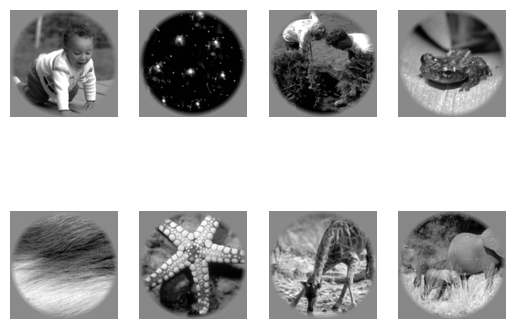

In [4]:
# @title Visualizing example images
############## TO DO ###############

for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(dat['stimuli'][i], cmap='gray')
  plt.axis('off')

plt.show()

---
# Dataset Structure

While using the neural networks, we have to be careful about the dimensions and the stimuli we are feeding the network with.

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

Based of Letcures, describe roi and roi_names and match with the dataset?
roi names include 'Other', 'V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LatOcc'. These are areas involved in the visual pathway of brain which was disscussed in the previous section. roi inculdes the index corresponding to the names
############## TO DO ###############

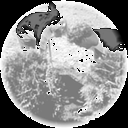

In [26]:
from google.colab.patches import cv2_imshow
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
############## TO DO ###############

roi = dat["roi"]
roi_names = dat["roi_names"]

# Convert grayscale images to RGB by repeating the grayscale channel
for i in range(3):
  stimuli_tr_xformed[:, i, :, :] = (stimuli_tr*255).astype(np.uint8)
  stimuli_ts_xformed[:, i, :, :] = (stimuli_ts*255).astype(np.uint8)

cv2_imshow(stimuli_tr_xformed[2].transpose([1, 2, 0]))

rois = roi_names[roi]
roi_sizes = [sum(roi==x) for x in range(8)]


---
# Fine Tuning AlexNet on voxel activations





It is previously demonstrated that simple features are extracted in the early layers of the neural network, so it is a good idea to use pre-trained nets which are trained on enormous data sets and just modify the final layers.

1- Search about fine tuning. Why do we fine tune in the first place?
fine tuning is performed to adapt a pre-trained neural network to a new task. The main reasons include: less traing time and no need to train from scratch, avoid overfitting for small dataset, improving performance
2- Search about different situations where fine tuning is done.
When small data is available or training from scratch is time consuming or for transfer learning to adapt the model to new data.
3- Name the different layers that are present in AlexNet. Briefly explain each layer's role. On what layers do we perform fine tuning>
Conv1, Conv2, Conv3, Conv4, Conv5 are convolutional layers. First layers extract basic features and last ones extract more complex features.
Max pooling layers reduce spatial dimensions, providing translation invariance and reducing computational load.
ReLU Activations: creates non-linearity.
Fully Connected Layers:
FC1 and FC2 Aggregate features learned by convolutional layers to make decisions.
Output Layer Produces final classification results.

We usually perform fine tuning on the last layers since they have more effect on the output and first layers only extract features.

In [27]:
# @title Setting up training and test data for LOC region (roc = 7)
############## TO DO ###############
print(roi_names)
response_tr = dat['responses'][:, roi==7]
response_ts = dat['responses_test'][:, roi==7]

['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


When and Why we use transform function for dataset.
We use transformation for cleaning or augmenting new data.
We use transformations to have an efficient and stable training, Also makes the model consistent for all data. Also, new data can be generated by transformation.
############## TO DO ###############

In [28]:
# @title Custom dataloader for loading images in numpy array
from torchvision.transforms import v2

# use MyDatast or use your own dataloader.
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.Tensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)

############## TO DO ###############
# complete transforms
transform = {
    'train': transforms.Compose([
        # transforms.Resize((128, 128)), Image sizes are already 128*128
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize((128, 128)), Image sizes are already 128*128
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225])
    ]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=50) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
<ipython-input-28-4185044e54e4>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.targets = torch.Tensor(targets)


In [31]:
# Training on pretrained alexnet and find best wieghts on epochs,
#finally load best weights
############## TO DO ###############

# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze all layers
#for param in model.parameters():
#    param.requires_grad = False

# Modify the final layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, response_tr.shape[1])

# MSE loss function and SGD optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

def train_model(model, criterion, optimizer, num_epochs=30):
    best_model_wts = model.state_dict()
    min_loss = 1000

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, out in dataloaders[phase]:
                inputs = inputs.to(device)
                out = out.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, out)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss}')

            if phase == 'val' and epoch_loss < min_loss:
                min_loss =epoch_loss
                best_model_wts = model.state_dict()


    print(f'Minimum Loss: {min_loss}')

    # Loading model with best weights
    model.load_state_dict(best_model_wts)
    return model


best_model = train_model(model, criterion, optimizer, num_epochs=4)
torch.save(best_model.state_dict(), 'best_weights.pth')

################################
# Akhar tamrin crach kard GPU tamum shod bara dobare train kardan epoch kam gozashtam
#################################

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/3
----------
train Loss: 1.2324800746781486
val Loss: 0.2390587367117405
Epoch 1/3
----------
train Loss: 0.9983072280883789
val Loss: 0.2385856012503306
Epoch 2/3
----------
train Loss: 0.9979857070105417
val Loss: 0.23856817682584128
Epoch 3/3
----------
train Loss: 0.9979373829705375
val Loss: 0.23843976110219955
Minimum Loss: 0.23843976110219955


why we extract intermediate layers freatures ?
We use them for many reasons including: understanding model behaviour or debugging. Also the features can be used for other tasks, for example compressing data in auto-encoders
############## TO DO ###############

In [33]:
from torchvision.models.feature_extraction import create_feature_extractor

## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    'classifier.1': 'fc1',
    'classifier.4': 'fc2',
    'classifier.6': 'fc3',
    }

layer_names = list(return_layers.values())

# Loading AlexNet pretrained on Imagenet
############## TO DO ###############

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Pretrained model
alex_net = models.alexnet(pretrained=True)
alex_net.to(device)
alex_net.eval()

model.load_state_dict(torch.load('best_weights.pth'))
model.to(device)
model.eval()

# Setting up feature extraction step
############## TO DO ###############

mid_getter_model = MidGetter(model, return_layers=return_layers, keep_output=True)
mid_getter_alex_net  = MidGetter(alex_net , return_layers=return_layers, keep_output=True)

# Loading validation data and forward pass through the network
############## TO DO ###############

inputs = []

for batch in dataloaders['val']:
    input_val, labels = batch
    inputs.append(input_val)

#inputs = torch.cat(inputs).cuda()
inputs = torch.cat(inputs)

with torch.no_grad():
    mid_outputs_alex_net, model_output = mid_getter_alex_net(inputs)
    mid_outputs_model, model_output = mid_getter_model(inputs)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


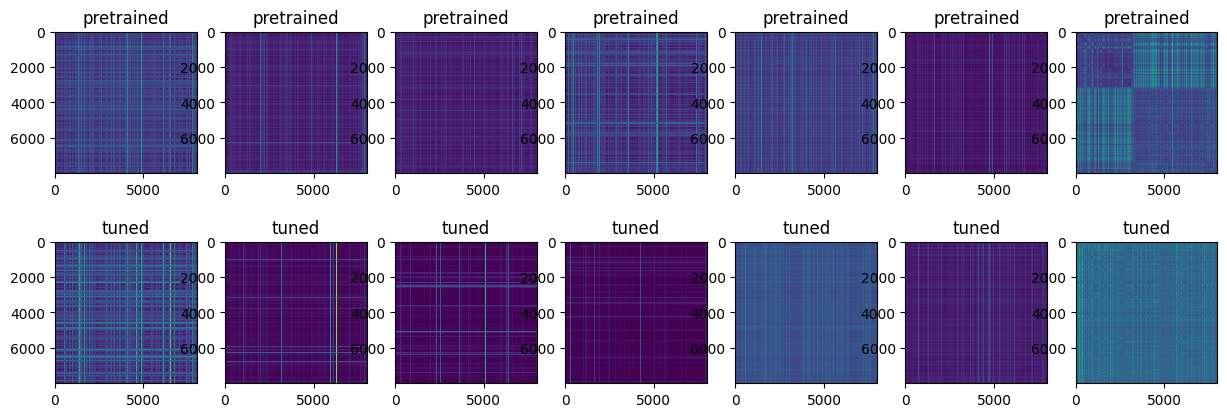

In [85]:
# @title Dissimilarity - Correlation
# Loading V1 (roi = 1) and LOC (roi = 7) responses
############## TO DO ###############
import cv2

V1_response = dat['responses_test'][:, roi==1]
V1_response_dissimilartiy = squareform(pdist(V1_response.T))

LOC_response = dat['responses_test'][:, roi==7]
LOC_response_dissimilarity = squareform(pdist(LOC_response.T))

# Observed dissimilarity  - Correlation
############## TO DO ###############

import torch.nn.functional as F

def downsample_tensor(input_tensor, output_length):
    scale_factor = input_tensor.size(-1) / output_length
    output_tensor = F.interpolate(input_tensor.unsqueeze(0), scale_factor=1/scale_factor, mode='linear').squeeze(0)

    return output_tensor


def calc_cor(image1, image2):
  height1, width1 = image1.shape
  height2, width2 = image2.shape

  new_height = min(height1, height2)
  new_width = min(width1, width2)

  # Resize images
  image1_resized = cv2.resize(image1, (new_width, new_height))
  image2_resized = cv2.resize(image2, (new_width, new_height))

  # Calculate the correlation coefficient
  return np.corrcoef(image1_resized.flatten(), image2_resized.flatten())[0, 1]


# Comparing representation of V1 and LOC across different layers of Alexnet
############## TO DO ###############

pretrained_dissim = []
tuned_dissim = []
pretrained_V1_cor = []
pretrained_LOC_cor = []
tuned_V1_cor = []
tuned_LOC_cor = []

layer_names = list(return_layers.values())

fig, ax = plt.subplots(2, 7, figsize=(15, 5))

for i in range(1, 8):
  features_tuned = mid_outputs_model[layer_names[i]]
  features_tuned = features_tuned.view(features_tuned.size(0), -1)
  features_tuned = downsample_tensor(features_tuned, 8000).T
  dist = squareform(pdist(features_tuned.cpu().numpy()))
  tuned_V1_cor.append(calc_cor(V1_response_dissimilartiy, dist))
  tuned_LOC_cor.append(calc_cor(LOC_response_dissimilarity, dist))
  ax[1, i-1].imshow(dist)
  ax[1, i-1].set_title('tuned')

  features_pretrained = mid_outputs_alex_net[layer_names[i]]
  features_pretrained = features_pretrained.view(features_pretrained.size(0), -1)
  features_pretrained = downsample_tensor(features_pretrained, 8000).T
  dist = squareform(pdist(features_pretrained.cpu().numpy()))
  pretrained_V1_cor.append(calc_cor(V1_response_dissimilartiy, dist))
  pretrained_LOC_cor.append(calc_cor(LOC_response_dissimilarity, dist))
  ax[0, i-1].imshow(dist)
  ax[0, i-1].set_title('pretrained')




In [91]:
# @title Plotting correlation between observed and predicted dissimilarity values
############## TO DO ###############

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

layer_names = list(return_layers.values())[1:]

# Match to V1
x = np.arange(len(layer_names))
width = 0.35
axs[0].bar(x - width/2, abs(np.array(pretrained_V1_cor)), width, label='Imagenet', color='orange')
axs[0].bar(x + width/2, abs(np.array(tuned_V1_cor)), width, label='Fine Tuned', color='skyblue')
axs[0].set_xlabel('Layers')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].set_title('Match to V1')
axs[0].set_xticks(x)
axs[0].set_xticklabels(layer_names)
axs[0].legend()

# Match to LOC
axs[1].bar(x - width/2, abs(np.array(pretrained_LOC_cor)), width, label='Imagenet', color='orange')
axs[1].bar(x + width/2, abs(np.array(tuned_LOC_cor)), width, label='Fine Tuned', color='skyblue')
axs[1].set_xlabel('Layers')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_title('Match to LOC')
axs[1].set_xticks(x)
axs[1].set_xticklabels(layer_names)
axs[1].legend()

plt.tight_layout()
plt.show()

**Describle Results in details :**
Dissimilarity of LOC responce is closer to last layers of network than first layers it. Also, closer in fine tuned than imagenet. In addition,Dissimilarity of V1 responce is closer to first convolutional layers of the network which extract basic features than last layers it. Also, closer in fine tuned than imagenet.